In [71]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor, DummyClassifier

sys.path.append('../')
from utils import utils

%matplotlib inline

In [51]:
%load_ext autore`load
%autoreload 2

In [7]:
# Load data
boston = load_boston()
# Shuffle the data
X, y = shuffle(boston.data, boston.target, random_state=123)
X.shape, y.shape

((506, 13), (506,))

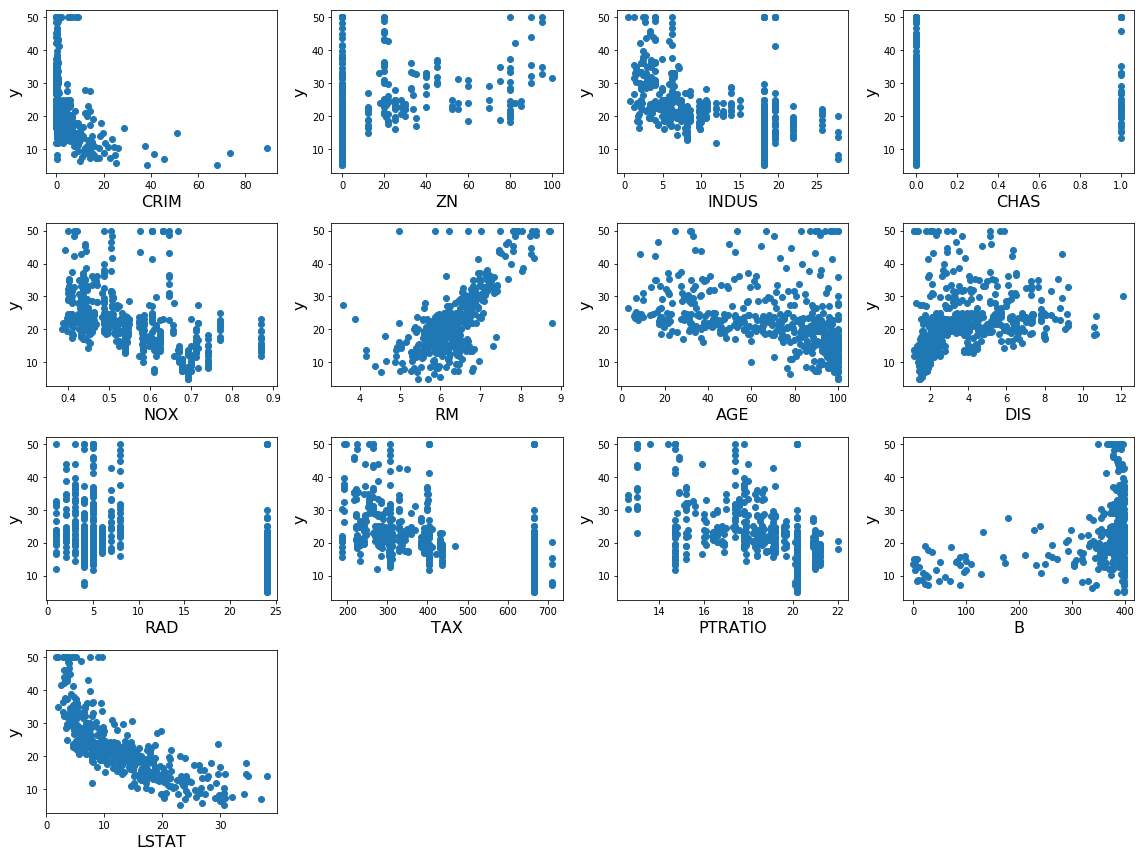

In [53]:
utils.plot_features_vs_target(X, y, boston.feature_names, n_rows=4, n_cols=4)

In [58]:
# Build dummy regressor
dummy = DummyRegressor(strategy='mean')
cross_val_score(dummy, X, y)

array([-0.00041149, -0.00083216, -0.00288347])

In [57]:
# RF baseline
rf = RandomForestRegressor()
cross_val_score(rf, X, y)

array([0.80325411, 0.90116266, 0.83656036])

In [59]:
# Let's try to compare R2 on two subsets of data:
# One on Charles river and one not along charles river

# Along charles river
rf = RandomForestRegressor()
cross_val_score(rf, X[X[:, 3] == 1], y[X[:, 3] == 1])

array([0.28480747, 0.72882074, 0.7343201 ])

In [60]:
# Not along charles river
rf = RandomForestRegressor()
cross_val_score(rf, X[X[:, 3] == 0], y[X[:, 3] == 0])

array([0.82122681, 0.87069366, 0.83586363])

Can we say that houses along *Charles river* are harder to predict because they have lower CV-R2?
We can't conclude that from the above because we're running CV-R2 on two different datasets that don't necessarily have the same variance --> Can't compare R2 since it's defined as the variance explained by the model.

In [62]:
# Try MSE
# Along charles river
rf = RandomForestRegressor()
-cross_val_score(rf, X[X[:, 3] == 1], y[X[:, 3] == 1], scoring='neg_mean_squared_error')

array([123.79556667,  44.020225  ,  11.36586364])

All metrics in `cross_val_score`: **bigger are better** --> Use neg_MSE

In [63]:
# Not along charles river
rf = RandomForestRegressor()
-cross_val_score(rf, X[X[:, 3] == 0], y[X[:, 3] == 0], scoring='neg_mean_squared_error')

array([12.91652675, 12.1431242 , 12.69592102])

Now, we can safely say that houses long the charles river are harder to predict.

In [64]:
# Try MSE
# Along charles river
rf = RandomForestRegressor()
-cross_val_score(rf, X[X[:, 3] == 1], y[X[:, 3] == 1], scoring='neg_mean_absolute_error')

array([6.68      , 5.23416667, 3.49636364])

In [65]:
# Not along charles river
rf = RandomForestRegressor()
-cross_val_score(rf, X[X[:, 3] == 0], y[X[:, 3] == 0], scoring='neg_mean_absolute_error')

array([2.56522293, 2.36745223, 2.2655414 ])

In [68]:
from sklearn.datasets import load_digits
digits = load_digits()
sevens = digits.target == 7

In [77]:
# Building dummy clf
dummy = DummyClassifier(strategy='most_frequent')

print(f'Dummy clf accuracy : {cross_val_score(dummy, digits.data, sevens)}')
print(f'Dummy clf AUC : {cross_val_score(dummy, digits.data, sevens, scoring="roc_auc")}')
print(f'Dummy clf average_precision : {cross_val_score(dummy, digits.data, sevens, scoring="average_precision")}')

Dummy clf accuracy : [0.9        0.89983306 0.90133779]
Dummy clf AUC : [0.5 0.5 0.5]
Dummy clf average_precision : [0.1        0.10016694 0.09866221]


In [78]:
# Build rf clf
rf_clf = RandomForestClassifier()
print(f'rf clf accuracy : {cross_val_score(rf, digits.data, sevens)}')
print(f'rf clf AUC : {cross_val_score(rf, digits.data, sevens, scoring="roc_auc")}')
print(f'rf clf average_precision : {cross_val_score(rf, digits.data, sevens, scoring="average_precision")}')

rf clf accuracy : [0.71704488 0.72099309 0.78498934]
rf clf AUC : [0.96784369 0.99298493 0.99302212]
rf clf average_precision : [0.91804834 0.95911201 0.93975823]


In [81]:
# Label binarizer
target = LabelBinarizer().fit_transform(digits.target)
target

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [84]:
# Build rf clf
rf_clf = RandomForestClassifier()
print(f'rf clf AUC : {cross_val_score(rf, digits.data, target, scoring="roc_auc")}')
print(f'rf clf average_precision : {cross_val_score(rf, digits.data, target, scoring="average_precision")}')

rf clf AUC : [0.97819861 0.99305681 0.96267961]
rf clf average_precision : [0.89088786 0.9516659  0.91844341]


**MAE** can be used if we want to report the error in the units as the target variable; however, **MSE** isn't helpful in this case.

**Conclusion**:
- R2 is not a good metric to compare models/predictions using different datasets
- MAE enables use to do the comparison plus gives us the error in terms of the target unit.
- Accuracy is not a good scoring metric to use especially with imbalanced data.
- ROC AUC and average_precision are good metrics to use. With sever class imbalances, average_precision is better to use.
- ROC AUC and average_precision are only for binary classification. To use them on multi-class classification, encode the data using LabelBinarizer() or LabelEncoder() 